
True Positives, False Positives, and False Negatives per VCF:

  5x  FASTQ : True Positives = 562350, False Positives = 35926, False Negatives = 420099
  5x  BAM : True Positives = 401233, False Positives = 56136, False Negatives = 581216
  10x  FASTQ : True Positives = 766478, False Positives = 49299, False Negatives = 215971
  10x  BAM : True Positives = 488969, False Positives = 42983, False Negatives = 493480
  15x  FASTQ : True Positives = 837883, False Positives = 54830, False Negatives = 144566
  15x  BAM : True Positives = 571078, False Positives = 63860, False Negatives = 411371
  20x  FASTQ : True Positives = 869971, False Positives = 53573, False Negatives = 112478
  20x  BAM : True Positives = 855515, False Positives = 90325, False Negatives = 126934
  36x  FASTQ : True Positives = 913380, False Positives = 56657, False Negatives = 69069
  36x  BAM : True Positives = 900085, False Positives = 168343, False Negatives = 82364
  5x  FASTQ : True Positives = 5541, False Positi

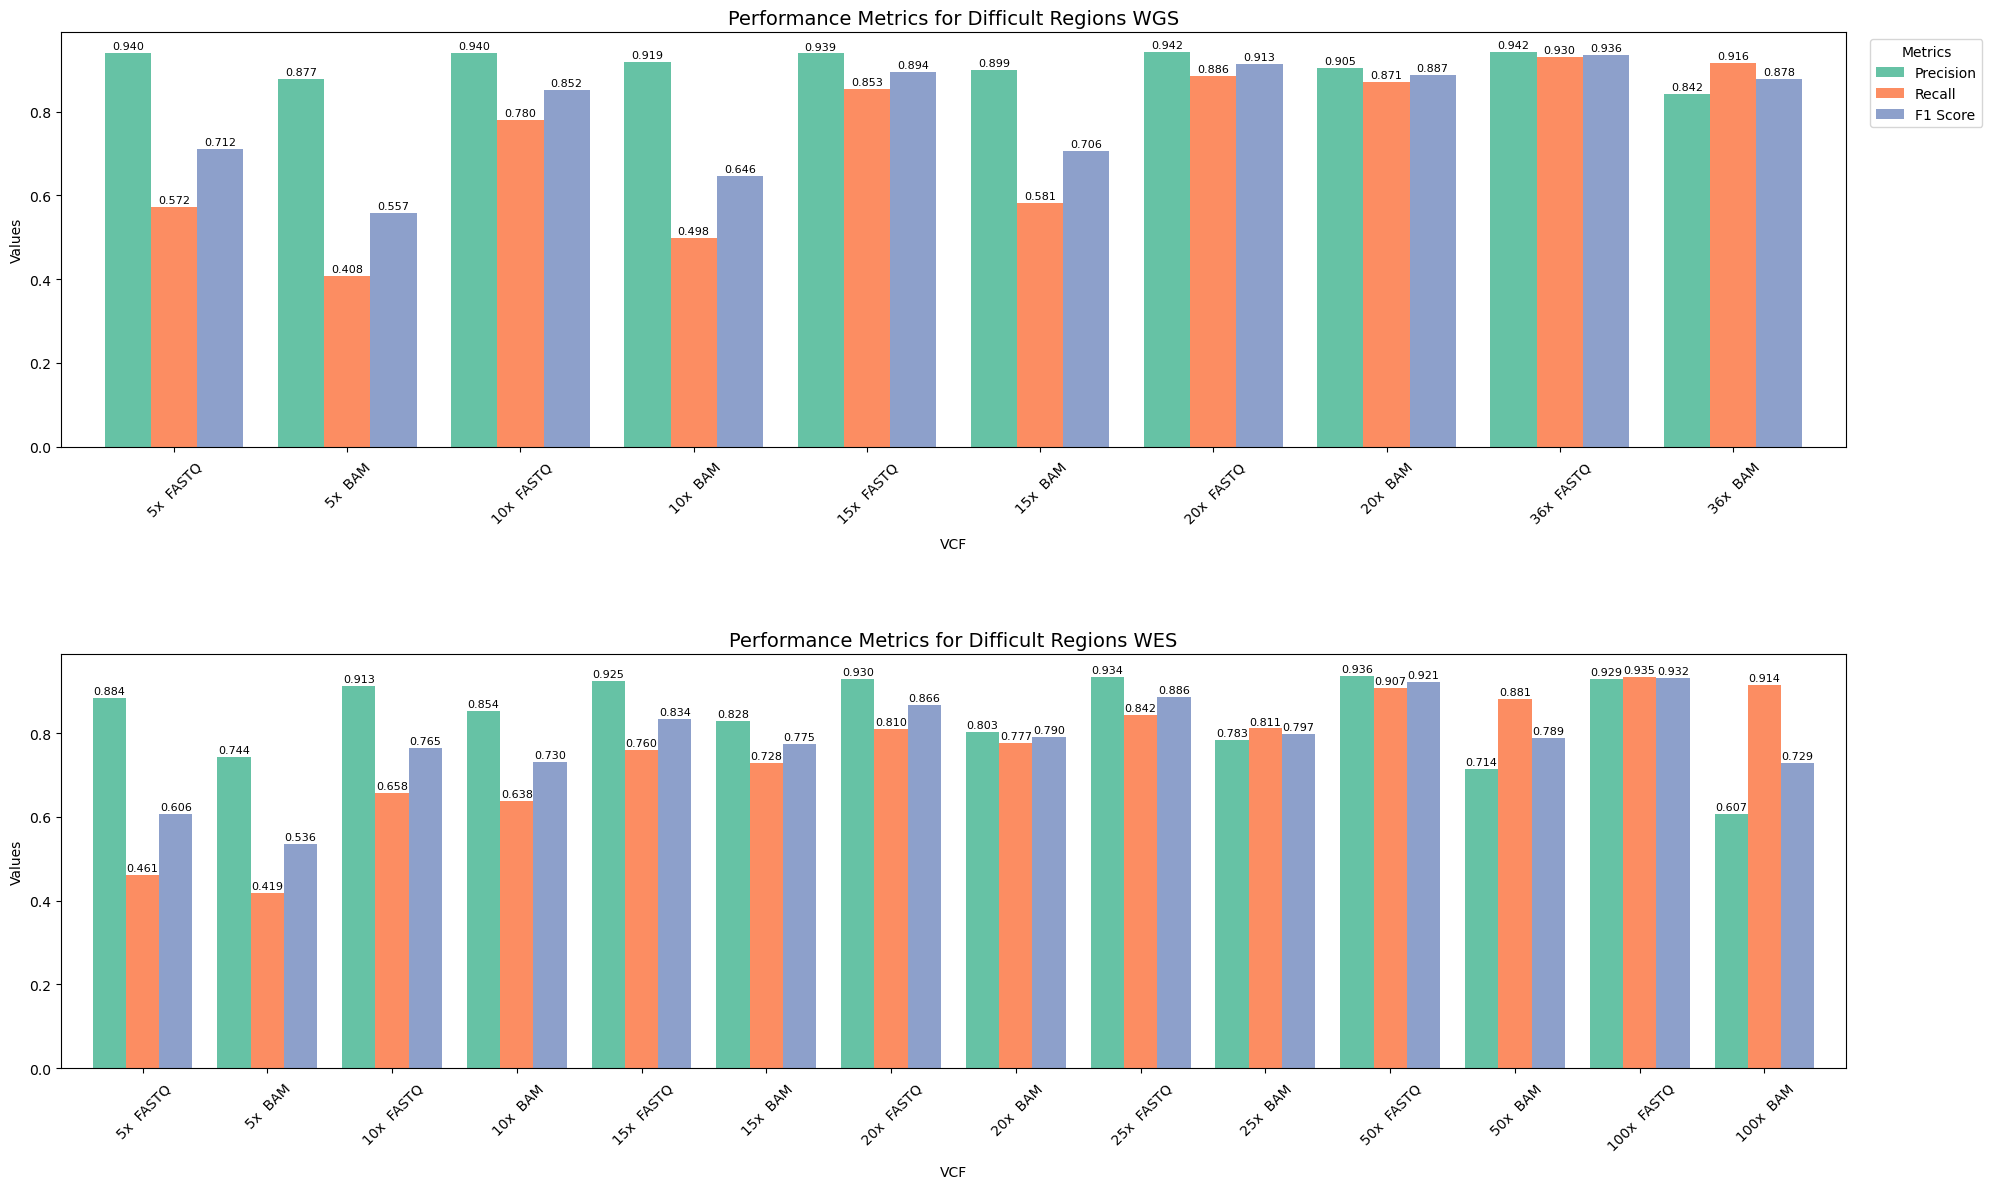

In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from cyvcf2 import VCF
import os

# Base directory for all VCF files
BASE_DIR = "Difficult Regions"

# Store reference files and sample VCFs for wgs and wes
datasets = {
    'wgs': {
        'reference': 'wgs_HG002_GRCh38_1_22_v4.2.1_benchmark_difficult_regions.vcf',
        'vcf_files': [
            'wgs_5x_FASTQ_difficult_regions.vcf', 'wgs_5x_BAM_difficult_regions.vcf',
            'wgs_10x_FASTQ_difficult_regions.vcf', 'wgs_10x_BAM_difficult_regions.vcf',
            'wgs_15x_FASTQ_difficult_regions.vcf', 'wgs_15x_BAM_difficult_regions.vcf',
            'wgs_20x_FASTQ_difficult_regions.vcf', 'wgs_20x_BAM_difficult_regions.vcf',
            'wgs_36x_FASTQ_difficult_regions.vcf', 'wgs_36x_BAM_difficult_regions.vcf',
            'wgs_HG002_GRCh38_1_22_v4.2.1_benchmark_difficult_regions.vcf'  # Will be removed from plot later
        ]
    },
    'wes': {
        'reference': 'wes_HG002_GRCh38_1_22_v4.2.1_benchmark_difficult_regions.vcf',
        'vcf_files': [
            'wes_5x_FASTQ_difficult_regions.vcf', 'wes_5x_BAM_difficult_regions.vcf',
            'wes_10x_FASTQ_difficult_regions.vcf', 'wes_10x_BAM_difficult_regions.vcf',
            'wes_15x_FASTQ_difficult_regions.vcf', 'wes_15x_BAM_difficult_regions.vcf',
            'wes_20x_FASTQ_difficult_regions.vcf', 'wes_20x_BAM_difficult_regions.vcf',
            'wes_25x_FASTQ_difficult_regions.vcf', 'wes_25x_BAM_difficult_regions.vcf',
            'wes_50x_FASTQ_difficult_regions.vcf', 'wes_50x_BAM_difficult_regions.vcf',
            'wes_100x_FASTQ_difficult_regions.vcf', 'wes_100x_BAM_difficult_regions.vcf',
            'wes_HG002_GRCh38_1_22_v4.2.1_benchmark_difficult_regions.vcf'  # Will be removed from plot later
        ]
    }
}

# Prepend BASE_DIR to all paths
for variant_type, data in datasets.items():
    data['reference'] = os.path.join(BASE_DIR, data['reference'])
    data['vcf_files'] = [os.path.join(BASE_DIR, f) for f in data['vcf_files']]

# Container for results
all_metrics = []

# Process both wgs and wes
for variant_type, data in datasets.items():
    vcf_reference = VCF(data['reference'])
    variants_ref = set((v.CHROM, v.POS, v.REF, tuple(v.ALT)) for v in vcf_reference)

    for vcf_file in data['vcf_files']:
        if vcf_file == data['reference']:  # Skip plotting reference
            continue

        vcf = VCF(vcf_file)
        variants_sample = set((v.CHROM, v.POS, v.REF, tuple(v.ALT)) for v in vcf)

        true_positive = len(variants_sample & variants_ref)
        false_positive = len(variants_sample - variants_ref)
        false_negative = len(variants_ref - variants_sample)

        precision = true_positive / (true_positive + false_positive) if (true_positive + false_positive) > 0 else 0
        recall = true_positive / (true_positive + false_negative) if (true_positive + false_negative) > 0 else 0
        f1_score = 2 * precision * recall / (precision + recall) if (precision + recall) > 0 else 0

        all_metrics.append({
            'VCF': vcf_file,
            'Precision': precision,
            'Recall': recall,
            'F1 Score': f1_score,
            'Total Variants': true_positive + false_positive,
            'True Positives': true_positive,
            'False Positives': false_positive,
            'False Negatives': false_negative,
            'Type': variant_type
        })

# Convert to Pandas for plotting
df = pd.DataFrame(all_metrics)

# Simplify labels
def simplify_label(filename):
    return os.path.basename(filename).replace('.vcf', '').replace('_difficultregions', '') \
                   .replace('x', 'x ').replace('_', ' ').replace('wgs', ' ').replace('wes', ' ').replace('snps', ' ') \
                   .replace('difficult regions', '').replace('non difficult regions', '')

df['VCF'] = df['VCF'].apply(simplify_label)

# Split by type
df_wgs = df[df['Type'] == 'wgs'].copy()
df_wes = df[df['Type'] == 'wes'].copy()

# Reset index for plotting
df_wgs.reset_index(drop=True, inplace=True)
df_wes.reset_index(drop=True, inplace=True)

# Show TP/FP/FN counts
print("\nTrue Positives, False Positives, and False Negatives per VCF:\n")
for _, row in df.iterrows():
    print(f"{row['VCF']}: True Positives = {row['True Positives']}, "
          f"False Positives = {row['False Positives']}, False Negatives = {row['False Negatives']}")

# Create vertically stacked plots
fig, axes = plt.subplots(2, 1, figsize=(20, 12), sharey=True)

# Define colors matching Seaborn's Set2
custom_colors = ['#66c2a5', '#fc8d62', '#8da0cb']

# wgs plot
ax1 = df_wgs[['VCF', 'Precision', 'Recall', 'F1 Score']].plot(
    kind='bar', x='VCF', ax=axes[0], width=0.8, color=custom_colors
)
ax1.set_title('Performance Metrics for Difficult Regions WGS', fontsize=14)
ax1.set_ylabel('Values')
ax1.tick_params(axis='x', rotation=45)
ax1.legend(title='Metrics', bbox_to_anchor=(1.01, 1), loc='upper left')

for p in ax1.patches:
    if p.get_height() > 0:
        ax1.annotate(f'{p.get_height():.3f}',
                     (p.get_x() + p.get_width() / 2., p.get_height()),
                     ha='center', va='center', xytext=(0, 5),
                     textcoords='offset points', fontsize=8)

# wes plot
ax2 = df_wes[['VCF', 'Precision', 'Recall', 'F1 Score']].plot(
    kind='bar', x='VCF', ax=axes[1], width=0.8, color=custom_colors, legend=False
)
ax2.set_title('Performance Metrics for Difficult Regions WES', fontsize=14)
ax2.set_ylabel('Values')
ax2.tick_params(axis='x', rotation=45)

for p in ax2.patches:
    if p.get_height() > 0:
        ax2.annotate(f'{p.get_height():.3f}',
                     (p.get_x() + p.get_width() / 2., p.get_height()),
                     ha='center', va='center', xytext=(0, 5),
                     textcoords='offset points', fontsize=8)

plt.tight_layout()
plt.subplots_adjust(hspace=0.5)  # Increase spacing
plt.savefig("difficult_regions.png", dpi=300)
plt.show()



True Positives, False Positives, and False Negatives per VCF:

  5x  FASTQ   : True Positives = 397276, False Positives = 16353, False Negatives = 217008
  5x  BAM   : True Positives = 291557, False Positives = 40365, False Negatives = 322727
  10x  FASTQ   : True Positives = 524097, False Positives = 22894, False Negatives = 90187
  10x  BAM   : True Positives = 338432, False Positives = 24215, False Negatives = 275852
  15x  FASTQ   : True Positives = 561500, False Positives = 26408, False Negatives = 52784
  15x  BAM   : True Positives = 385737, False Positives = 35031, False Negatives = 228547
  20x  FASTQ   : True Positives = 575914, False Positives = 26535, False Negatives = 38370
  20x  BAM   : True Positives = 568152, False Positives = 51440, False Negatives = 46132
  36x  FASTQ   : True Positives = 591983, False Positives = 29908, False Negatives = 22301
  36x  BAM   : True Positives = 585934, False Positives = 107442, False Negatives = 28350
  5x  FASTQ   : True Positives = 

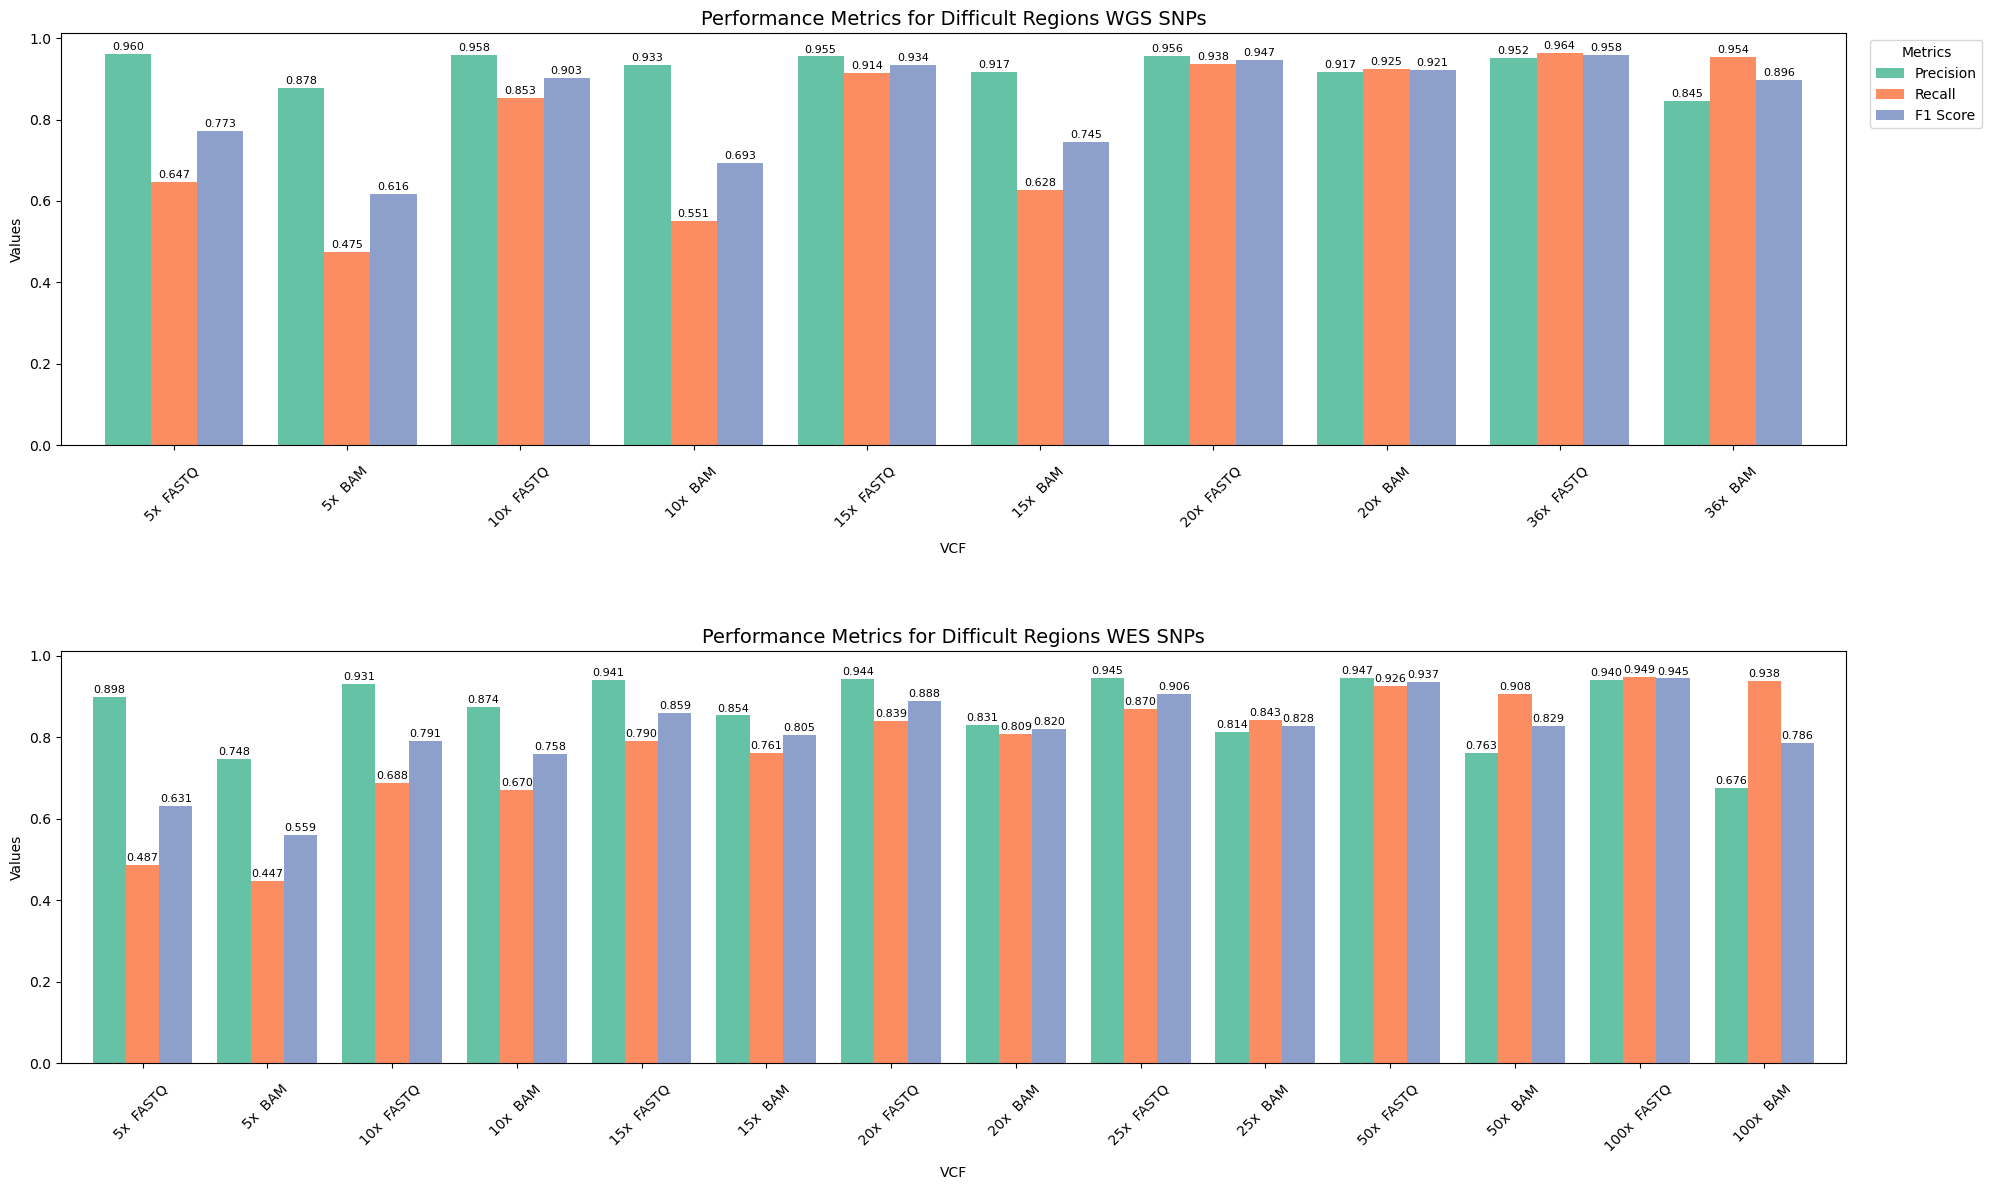

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from cyvcf2 import VCF
import os

# Base directory for all VCF files
BASE_DIR = "Difficult Regions/snps"

# Store reference files and sample VCFs for wgs and wes
datasets = {
    'wgs': {
        'reference': 'wgs_HG002_GRCh38_1_22_v4.2.1_benchmark_difficult_regions_snps.vcf',
        'vcf_files': [
            'wgs_5x_FASTQ_difficult_regions_snps.vcf', 'wgs_5x_BAM_difficult_regions_snps.vcf',
            'wgs_10x_FASTQ_difficult_regions_snps.vcf', 'wgs_10x_BAM_difficult_regions_snps.vcf',
            'wgs_15x_FASTQ_difficult_regions_snps.vcf', 'wgs_15x_BAM_difficult_regions_snps.vcf',
            'wgs_20x_FASTQ_difficult_regions_snps.vcf', 'wgs_20x_BAM_difficult_regions_snps.vcf',
            'wgs_36x_FASTQ_difficult_regions_snps.vcf', 'wgs_36x_BAM_difficult_regions_snps.vcf',
            'wgs_HG002_GRCh38_1_22_v4.2.1_benchmark_difficult_regions_snps.vcf'  # Will be removed from plot later
        ]
    },
    'wes': {
        'reference': 'wes_HG002_GRCh38_1_22_v4.2.1_benchmark_difficult_regions_snps.vcf',
        'vcf_files': [
            'wes_5x_FASTQ_difficult_regions_snps.vcf', 'wes_5x_BAM_difficult_regions_snps.vcf',
            'wes_10x_FASTQ_difficult_regions_snps.vcf', 'wes_10x_BAM_difficult_regions_snps.vcf',
            'wes_15x_FASTQ_difficult_regions_snps.vcf', 'wes_15x_BAM_difficult_regions_snps.vcf',
            'wes_20x_FASTQ_difficult_regions_snps.vcf', 'wes_20x_BAM_difficult_regions_snps.vcf',
            'wes_25x_FASTQ_difficult_regions_snps.vcf', 'wes_25x_BAM_difficult_regions_snps.vcf',
            'wes_50x_FASTQ_difficult_regions_snps.vcf', 'wes_50x_BAM_difficult_regions_snps.vcf',
            'wes_100x_FASTQ_difficult_regions_snps.vcf', 'wes_100x_BAM_difficult_regions_snps.vcf',
            'wes_HG002_GRCh38_1_22_v4.2.1_benchmark_difficult_regions_snps.vcf'  # Will be removed from plot later
        ]
    }
}

# Prepend BASE_DIR to all paths
for variant_type, data in datasets.items():
    data['reference'] = os.path.join(BASE_DIR, data['reference'])
    data['vcf_files'] = [os.path.join(BASE_DIR, f) for f in data['vcf_files']]

# Container for results
all_metrics = []

# Process both wgs and wes
for variant_type, data in datasets.items():
    vcf_reference = VCF(data['reference'])
    variants_ref = set((v.CHROM, v.POS, v.REF, tuple(v.ALT)) for v in vcf_reference)

    for vcf_file in data['vcf_files']:
        if vcf_file == data['reference']:  # Skip plotting reference
            continue

        vcf = VCF(vcf_file)
        variants_sample = set((v.CHROM, v.POS, v.REF, tuple(v.ALT)) for v in vcf)

        true_positive = len(variants_sample & variants_ref)
        false_positive = len(variants_sample - variants_ref)
        false_negative = len(variants_ref - variants_sample)

        precision = true_positive / (true_positive + false_positive) if (true_positive + false_positive) > 0 else 0
        recall = true_positive / (true_positive + false_negative) if (true_positive + false_negative) > 0 else 0
        f1_score = 2 * precision * recall / (precision + recall) if (precision + recall) > 0 else 0

        all_metrics.append({
            'VCF': vcf_file,
            'Precision': precision,
            'Recall': recall,
            'F1 Score': f1_score,
            'Total Variants': true_positive + false_positive,
            'True Positives': true_positive,
            'False Positives': false_positive,
            'False Negatives': false_negative,
            'Type': variant_type
        })

# Convert to Pandas for plotting
df = pd.DataFrame(all_metrics)

# Simplify labels
def simplify_label(filename):
    return os.path.basename(filename).replace('.vcf', '').replace('_difficultregions', '') \
                   .replace('x', 'x ').replace('_', ' ').replace('wgs', ' ').replace('wes', ' ').replace('snps', ' ') \
                   .replace('difficult regions', '').replace('non difficult regions', '')

df['VCF'] = df['VCF'].apply(simplify_label)

# Split by type
df_wgs = df[df['Type'] == 'wgs'].copy()
df_wes = df[df['Type'] == 'wes'].copy()

# Reset index for plotting
df_wgs.reset_index(drop=True, inplace=True)
df_wes.reset_index(drop=True, inplace=True)

# Show TP/FP/FN counts
print("\nTrue Positives, False Positives, and False Negatives per VCF:\n")
for _, row in df.iterrows():
    print(f"{row['VCF']}: True Positives = {row['True Positives']}, "
          f"False Positives = {row['False Positives']}, False Negatives = {row['False Negatives']}")

# Create vertically stacked plots
fig, axes = plt.subplots(2, 1, figsize=(20, 12), sharey=True)

# Define colors matching Seaborn's Set2
custom_colors = ['#66c2a5', '#fc8d62', '#8da0cb']

# wgs plot
ax1 = df_wgs[['VCF', 'Precision', 'Recall', 'F1 Score']].plot(
    kind='bar', x='VCF', ax=axes[0], width=0.8, color=custom_colors
)
ax1.set_title('Performance Metrics for Difficult Regions WGS SNPs', fontsize=14)
ax1.set_ylabel('Values')
ax1.tick_params(axis='x', rotation=45)
ax1.legend(title='Metrics', bbox_to_anchor=(1.01, 1), loc='upper left')

for p in ax1.patches:
    if p.get_height() > 0:
        ax1.annotate(f'{p.get_height():.3f}',
                     (p.get_x() + p.get_width() / 2., p.get_height()),
                     ha='center', va='center', xytext=(0, 5),
                     textcoords='offset points', fontsize=8)

# wes plot
ax2 = df_wes[['VCF', 'Precision', 'Recall', 'F1 Score']].plot(
    kind='bar', x='VCF', ax=axes[1], width=0.8, color=custom_colors, legend=False
)
ax2.set_title('Performance Metrics for Difficult Regions WES SNPs', fontsize=14)
ax2.set_ylabel('Values')
ax2.tick_params(axis='x', rotation=45)

for p in ax2.patches:
    if p.get_height() > 0:
        ax2.annotate(f'{p.get_height():.3f}',
                     (p.get_x() + p.get_width() / 2., p.get_height()),
                     ha='center', va='center', xytext=(0, 5),
                     textcoords='offset points', fontsize=8)

plt.tight_layout()
plt.subplots_adjust(hspace=0.5)  # Increase spacing
plt.savefig("difficult_regions_SNPs.png", dpi=300)
plt.show()



True Positives, False Positives, and False Negatives per VCF:

  5x  FASTQ   : True Positives = 165141, False Positives = 19696, False Negatives = 204271
  5x  BAM   : True Positives = 109703, False Positives = 15835, False Negatives = 259709
  10x  FASTQ   : True Positives = 242605, False Positives = 26701, False Negatives = 126807
  10x  BAM   : True Positives = 150669, False Positives = 18952, False Negatives = 218743
  15x  FASTQ   : True Positives = 276698, False Positives = 28871, False Negatives = 92714
  15x  BAM   : True Positives = 185532, False Positives = 29114, False Negatives = 183880
  20x  FASTQ   : True Positives = 294430, False Positives = 27569, False Negatives = 74982
  20x  BAM   : True Positives = 287718, False Positives = 39414, False Negatives = 81694
  36x  FASTQ   : True Positives = 321863, False Positives = 27394, False Negatives = 47549
  36x  BAM   : True Positives = 314586, False Positives = 61637, False Negatives = 54826
  5x  FASTQ   : True Positives = 

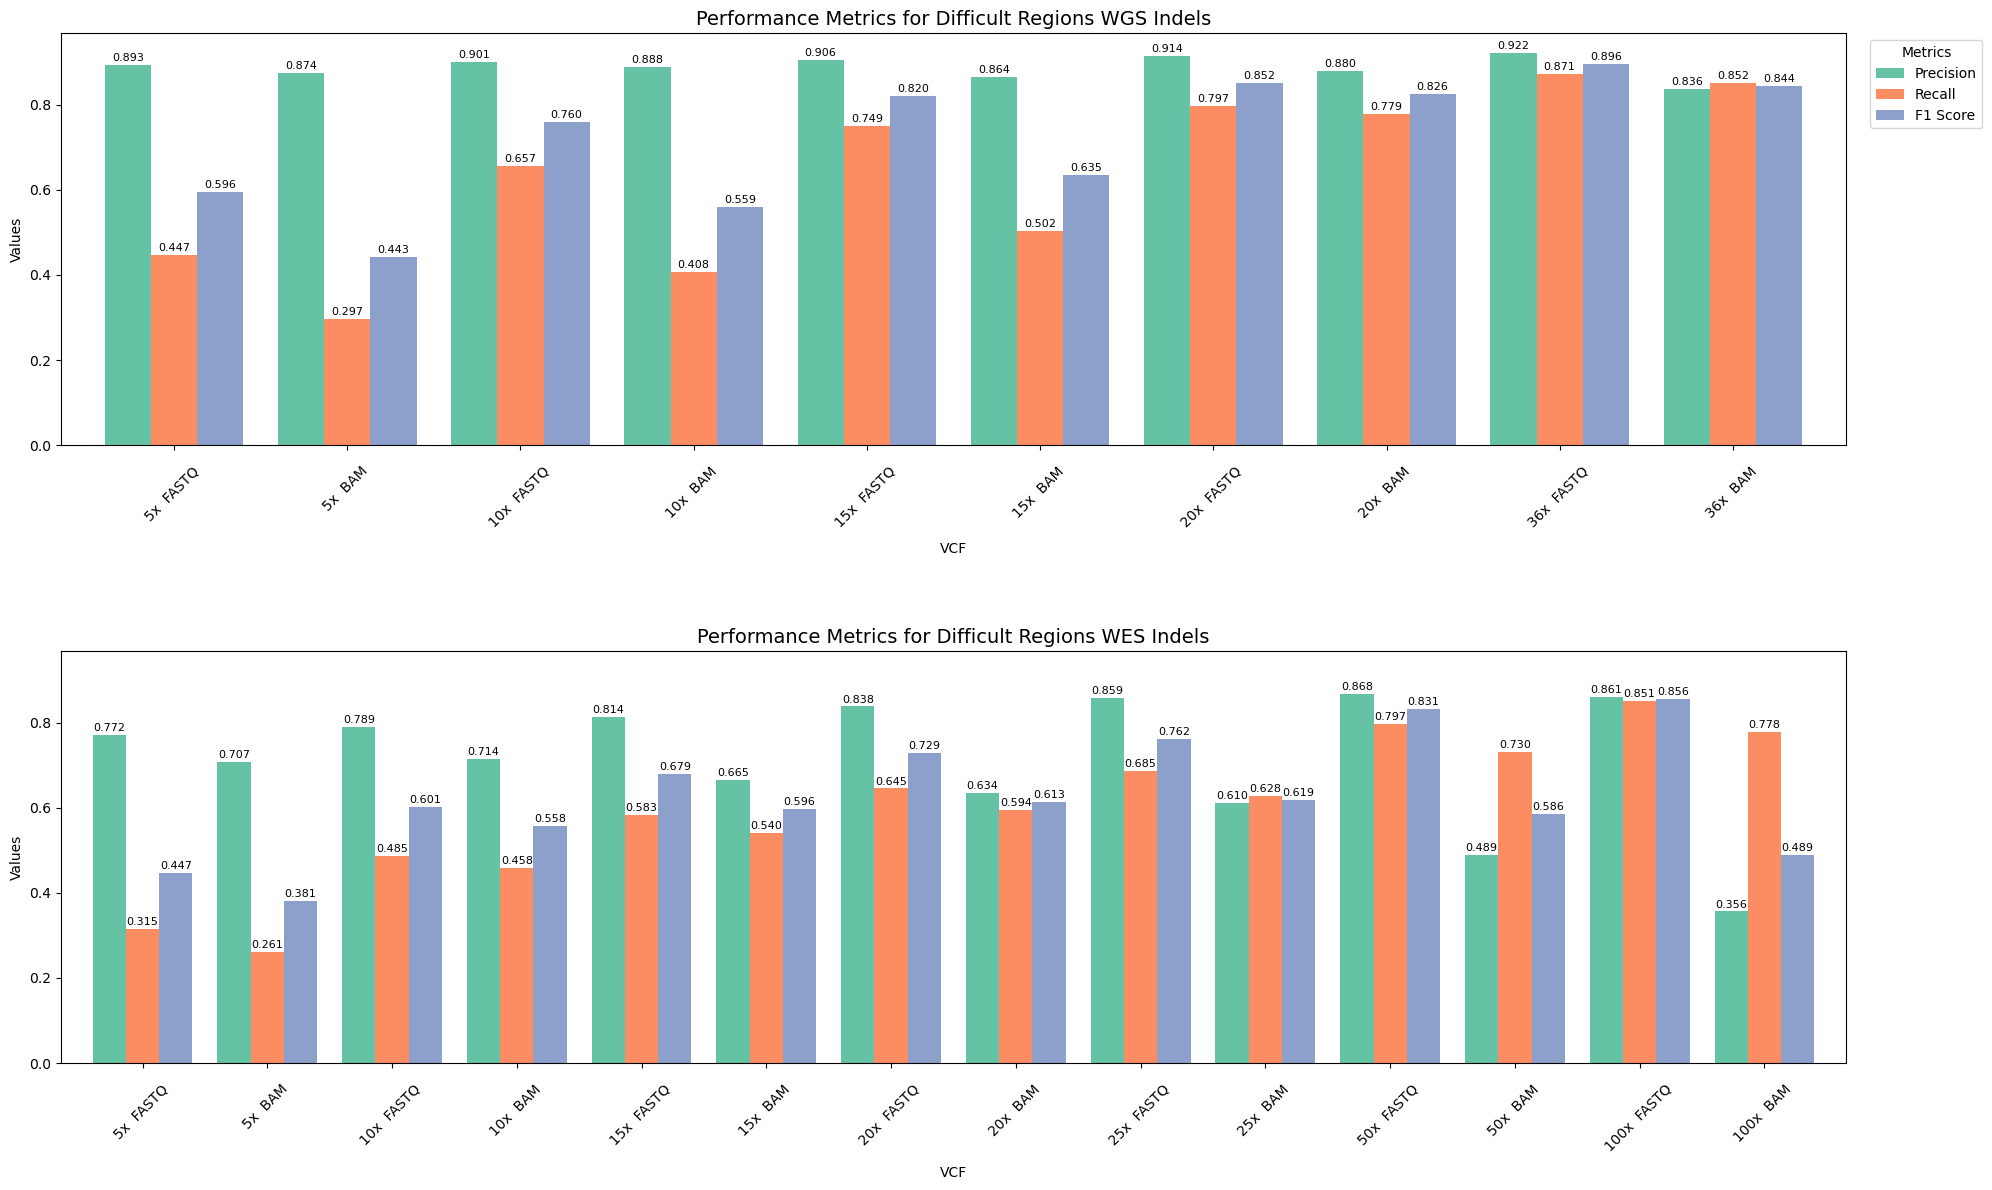

In [5]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from cyvcf2 import VCF
import os

# Base directory for all VCF files
BASE_DIR = "Difficult Regions/indels"

# Store reference files and sample VCFs for wgs and wes
datasets = {
    'wgs': {
        'reference': 'wgs_HG002_GRCh38_1_22_v4.2.1_benchmark_difficult_regions_indels.vcf',
        'vcf_files': [
            'wgs_5x_FASTQ_difficult_regions_indels.vcf', 'wgs_5x_BAM_difficult_regions_indels.vcf',
            'wgs_10x_FASTQ_difficult_regions_indels.vcf', 'wgs_10x_BAM_difficult_regions_indels.vcf',
            'wgs_15x_FASTQ_difficult_regions_indels.vcf', 'wgs_15x_BAM_difficult_regions_indels.vcf',
            'wgs_20x_FASTQ_difficult_regions_indels.vcf', 'wgs_20x_BAM_difficult_regions_indels.vcf',
            'wgs_36x_FASTQ_difficult_regions_indels.vcf', 'wgs_36x_BAM_difficult_regions_indels.vcf',
            'wgs_HG002_GRCh38_1_22_v4.2.1_benchmark_difficult_regions_indels.vcf'  # Will be removed from plot later
        ]
    },
    'wes': {
        'reference': 'wes_HG002_GRCh38_1_22_v4.2.1_benchmark_difficult_regions_indels.vcf',
        'vcf_files': [
            'wes_5x_FASTQ_difficult_regions_indels.vcf', 'wes_5x_BAM_difficult_regions_indels.vcf',
            'wes_10x_FASTQ_difficult_regions_indels.vcf', 'wes_10x_BAM_difficult_regions_indels.vcf',
            'wes_15x_FASTQ_difficult_regions_indels.vcf', 'wes_15x_BAM_difficult_regions_indels.vcf',
            'wes_20x_FASTQ_difficult_regions_indels.vcf', 'wes_20x_BAM_difficult_regions_indels.vcf',
            'wes_25x_FASTQ_difficult_regions_indels.vcf', 'wes_25x_BAM_difficult_regions_indels.vcf',
            'wes_50x_FASTQ_difficult_regions_indels.vcf', 'wes_50x_BAM_difficult_regions_indels.vcf',
            'wes_100x_FASTQ_difficult_regions_indels.vcf', 'wes_100x_BAM_difficult_regions_indels.vcf',
            'wes_HG002_GRCh38_1_22_v4.2.1_benchmark_difficult_regions_indels.vcf'  # Will be removed from plot later
        ]
    }
}

# Prepend BASE_DIR to all paths
for variant_type, data in datasets.items():
    data['reference'] = os.path.join(BASE_DIR, data['reference'])
    data['vcf_files'] = [os.path.join(BASE_DIR, f) for f in data['vcf_files']]

# Container for results
all_metrics = []

# Process both wgs and wes
for variant_type, data in datasets.items():
    vcf_reference = VCF(data['reference'])
    variants_ref = set((v.CHROM, v.POS, v.REF, tuple(v.ALT)) for v in vcf_reference)

    for vcf_file in data['vcf_files']:
        if vcf_file == data['reference']:  # Skip plotting reference
            continue

        vcf = VCF(vcf_file)
        variants_sample = set((v.CHROM, v.POS, v.REF, tuple(v.ALT)) for v in vcf)

        true_positive = len(variants_sample & variants_ref)
        false_positive = len(variants_sample - variants_ref)
        false_negative = len(variants_ref - variants_sample)

        precision = true_positive / (true_positive + false_positive) if (true_positive + false_positive) > 0 else 0
        recall = true_positive / (true_positive + false_negative) if (true_positive + false_negative) > 0 else 0
        f1_score = 2 * precision * recall / (precision + recall) if (precision + recall) > 0 else 0

        all_metrics.append({
            'VCF': vcf_file,
            'Precision': precision,
            'Recall': recall,
            'F1 Score': f1_score,
            'Total Variants': true_positive + false_positive,
            'True Positives': true_positive,
            'False Positives': false_positive,
            'False Negatives': false_negative,
            'Type': variant_type
        })

# Convert to Pandas for plotting
df = pd.DataFrame(all_metrics)

# Simplify labels
def simplify_label(filename):
    return os.path.basename(filename).replace('.vcf', '').replace('_difficultregions', '') \
                   .replace('x', 'x ').replace('_', ' ').replace('wgs', ' ').replace('wes', ' ').replace('indels', ' ') \
                   .replace('difficult regions', '').replace('non difficult regions', '')

df['VCF'] = df['VCF'].apply(simplify_label)

# Split by type
df_wgs = df[df['Type'] == 'wgs'].copy()
df_wes = df[df['Type'] == 'wes'].copy()

# Reset index for plotting
df_wgs.reset_index(drop=True, inplace=True)
df_wes.reset_index(drop=True, inplace=True)

# Show TP/FP/FN counts
print("\nTrue Positives, False Positives, and False Negatives per VCF:\n")
for _, row in df.iterrows():
    print(f"{row['VCF']}: True Positives = {row['True Positives']}, "
          f"False Positives = {row['False Positives']}, False Negatives = {row['False Negatives']}")

# Create vertically stacked plots
fig, axes = plt.subplots(2, 1, figsize=(20, 12), sharey=True)

# Define colors matching Seaborn's Set2
custom_colors = ['#66c2a5', '#fc8d62', '#8da0cb']

# wgs plot
ax1 = df_wgs[['VCF', 'Precision', 'Recall', 'F1 Score']].plot(
    kind='bar', x='VCF', ax=axes[0], width=0.8, color=custom_colors
)
ax1.set_title('Performance Metrics for Difficult Regions WGS Indels', fontsize=14)
ax1.set_ylabel('Values')
ax1.tick_params(axis='x', rotation=45)
ax1.legend(title='Metrics', bbox_to_anchor=(1.01, 1), loc='upper left')

for p in ax1.patches:
    if p.get_height() > 0:
        ax1.annotate(f'{p.get_height():.3f}',
                     (p.get_x() + p.get_width() / 2., p.get_height()),
                     ha='center', va='center', xytext=(0, 5),
                     textcoords='offset points', fontsize=8)

# wes plot
ax2 = df_wes[['VCF', 'Precision', 'Recall', 'F1 Score']].plot(
    kind='bar', x='VCF', ax=axes[1], width=0.8, color=custom_colors, legend=False
)
ax2.set_title('Performance Metrics for Difficult Regions WES Indels', fontsize=14)
ax2.set_ylabel('Values')
ax2.tick_params(axis='x', rotation=45)

for p in ax2.patches:
    if p.get_height() > 0:
        ax2.annotate(f'{p.get_height():.3f}',
                     (p.get_x() + p.get_width() / 2., p.get_height()),
                     ha='center', va='center', xytext=(0, 5),
                     textcoords='offset points', fontsize=8)

plt.tight_layout()
plt.subplots_adjust(hspace=0.5)  # Increase spacing
plt.savefig("difficult_regions_indels.png", dpi=300)
plt.show()
